In [1]:
import gym
import sys
import numpy as np
import matplotlib
from collections import defaultdict
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


%matplotlib inline
matplotlib.style.use("ggplot")

In [2]:
def plot_value_function(V, title):
    """
    Plots the value function as a surface plot.
    """
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))
    
    def plot_surface(X, Y, Z, title=None):
        fig = plt.figure(figsize=(20, 10), facecolor='white')

        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player sum')
        ax.set_ylabel('Dealer showing')
        ax.set_zlabel('Value')
        if title: ax.set_title(title)
        ax.view_init(ax.elev, -120)
        ax.set_facecolor("white")
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "(No Usable Ace)")
    plot_surface(X, Y, Z_ace, "(Usable Ace)")

In [3]:

def random_policy(nA):
    "随机策略"
    def policy(state):
        action_prob = np.ones((nA), dtype=np.float32) / nA # 每个动作的选择概率相同，故随机选择所有的动作
        return action_prob
    return policy

def greedy_policy(action_values):
    "贪婪策略"
    def policy(state):
        optim_action = np.argmax(action_values[state])
        action_prob = np.zeros_like(action_values[state], dtype=np.float32)
        action_prob[optim_action] = 1.0
        return action_prob
    return policy

In [4]:
def mc_importance_everyvisit_control(environment, max_episodes=10000, episode_endtime=20, discount=1.0):
    """
        input: environment, max_episodes, episode_endtime, discount
        return: action_values
    """
    env = environment
    nA = env.action_space.n
    importance_weight_sum = defaultdict(lambda: np.zeros((nA), np.float32))
    action_values = defaultdict(lambda: np.zeros((nA), np.float32))

    "行为策略为随机选策略，目标策略为贪婪策略"
    behavior_policy = random_policy(nA)
    target_policy = greedy_policy(action_values)

    "对每一幕进行采样"
    for episode in range(max_episodes):
        state = env.reset()
        trajectory = []
        "1.收集一条经验轨迹"
        for t in range(episode_endtime):
            action_prob = behavior_policy(state)  # 根据行为策略获取动作选择概率
            action = np.random.choice(np.arange(len(action_prob)), p=action_prob)
            next_state, reward, done, _ = env.step(action)
            trajectory.append((state, action, reward))
            if(done):
                break
            state = next_state

        "2.根据经验轨迹进行加权平均"
        gain = 0
        w = 1
        Q, C = action_values, importance_weight_sum  # 别名
        for (state, action, reward) in trajectory[::-1]:
            gain = discount * gain + reward
            C[state][action] += w
            Q[state][action] += w / C[state][action]* (gain - Q[state][action])
            """ 
                定义式：w[t] = product(i-> t: T-1){target_policy_prob / behavior_policy_prob}
                迭代式（从T-1到0）：w = w * target_policy_prob / behavior_policy_prob 
                由于target_policy为确定性策略，若action不等于target_policy所选择的动作，则其概率为0
                因而迭代以后几项的w（重要性权重）都为0，故不需要概率之后的几项。
            """
            if(action!=np.argmax(target_policy(state))):
                break
            w = w* 1 / behavior_policy(state)[action] # 1表示确定性策略所选择的动作的动作概率

    return action_values


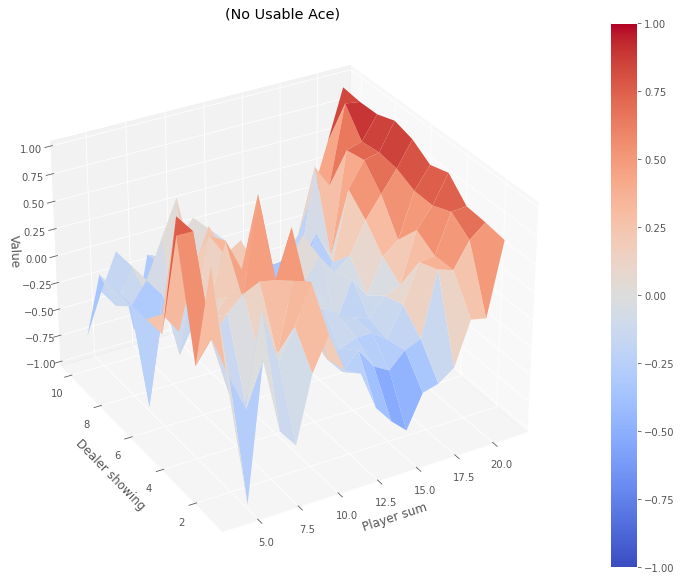

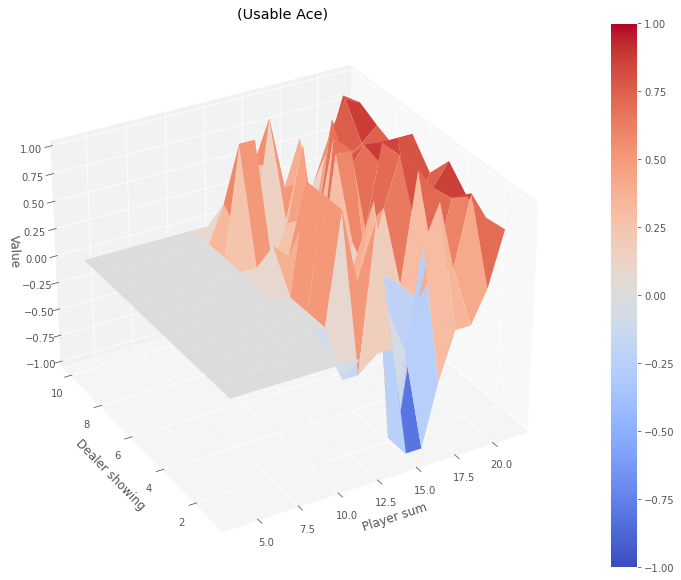

In [7]:
env = gym.make("Blackjack-v0")
action_values= mc_importance_everyvisit_control(env, 10000, 50)
v = defaultdict(float)
for state, values in action_values.items():
    v[state] = np.max(values)
plot_value_function(v, title="Optimal Value Function")

In [10]:
for state, value in sorted(v.items()):
    print(state, value)

(4, 1, False) 0.0
(4, 1, True) 0.0
(4, 2, False) 1.0
(4, 2, True) 0.0
(4, 3, False) -7.450581e-09
(4, 3, True) 0.0
(4, 4, False) 1.0
(4, 4, True) 0.0
(4, 5, False) 0.0
(4, 5, True) 0.0
(4, 6, False) 0.0
(4, 6, True) 0.0
(4, 7, False) 0.0
(4, 7, True) 0.0
(4, 8, False) 0.0
(4, 8, True) 0.0
(4, 9, False) 0.0
(4, 9, True) 0.0
(4, 10, False) -0.71428573
(4, 10, True) 0.0
(5, 1, False) -1.0
(5, 1, True) 0.0
(5, 2, False) 7.450581e-09
(5, 2, True) 0.0
(5, 3, False) 0.2
(5, 3, True) 0.0
(5, 4, False) 1.0
(5, 4, True) 0.0
(5, 5, False) 1.0
(5, 5, True) 0.0
(5, 6, False) 0.0
(5, 6, True) 0.0
(5, 7, False) -1.0
(5, 7, True) 0.0
(5, 8, False) -0.2
(5, 8, True) 0.0
(5, 9, False) -0.33333334
(5, 9, True) 0.0
(5, 10, False) -0.3333333
(5, 10, True) 0.0
(6, 1, False) 0.25
(6, 1, True) 0.0
(6, 2, False) -0.33333334
(6, 2, True) 0.0
(6, 3, False) -0.33333334
(6, 3, True) 0.0
(6, 4, False) 0.0
(6, 4, True) 0.0
(6, 5, False) 0.5
(6, 5, True) 0.0
(6, 6, False) -0.19999999
(6, 6, True) 0.0
(6, 7, False) 0.